### Import all relevant libraries

In [ ]:
pip install mlxtend

In [180]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import auc as sklearn_auc
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from itertools import cycle
import shap

### Loading the dataset

In [3]:
# Load the dataset
data = pd.read_csv('Occupancy_Estimation.csv')
data.head()

,Date,Time,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
0,2017/12/22,10:49:41,24.94,24.75,24.56,25.38,121,34,53,40,0.08,0.19,0.06,0.06,390,0.769231,0,0,1
1,2017/12/22,10:50:12,24.94,24.75,24.56,25.44,121,33,53,40,0.93,0.05,0.06,0.06,390,0.646154,0,0,1
2,2017/12/22,10:50:42,25.00,24.75,24.50,25.44,121,34,53,40,0.43,0.11,0.08,0.06,390,0.519231,0,0,1
3,2017/12/22,10:51:13,25.00,24.75,24.56,25.44,121,34,53,40,0.41,0.10,0.10,0.09,390,0.388462,0,0,1
4,2017/12/22,10:51:44,25.00,24.75,24.56,25.44,121,34,54,40,0.18,0.06,0.06,0.06,390,0.253846,0,0,1


### Exploratory Data Analysis

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10129 entries, 0 to 10128
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  10129 non-null  object 
 1   Time                  10129 non-null  object 
 2   S1_Temp               10129 non-null  float64
 3   S2_Temp               10129 non-null  float64
 4   S3_Temp               10129 non-null  float64
 5   S4_Temp               10129 non-null  float64
 6   S1_Light              10129 non-null  int64  
 7   S2_Light              10129 non-null  int64  
 8   S3_Light              10129 non-null  int64  
 9   S4_Light              10129 non-null  int64  
 10  S1_Sound              10129 non-null  float64
 11  S2_Sound              10129 non-null  float64
 12  S3_Sound              10129 non-null  float64
 13  S4_Sound              10129 non-null  float64
 14  S5_CO2                10129 non-null  int64  
 15  S5_CO2_Slope       

In [5]:
data.shape

(10129, 19)

In [6]:
data.describe()

,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
count,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.00000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000
mean,25.454012,25.546059,25.056621,25.754125,25.445059,26.01629,34.248494,13.220259,0.168178,0.120066,0.158119,0.103840,460.860401,-0.004830,0.090137,0.079574,0.398559
std,0.351351,0.586325,0.427283,0.356434,51.011264,67.30417,58.400744,19.602219,0.316709,0.266503,0.413637,0.120683,199.964940,1.164990,0.286392,0.270645,0.893633
min,24.940000,24.750000,24.440000,24.940000,0.000000,0.00000,0.000000,0.000000,0.060000,0.040000,0.040000,0.050000,345.000000,-6.296154,0.000000,0.000000,0.000000
25%,25.190000,25.190000,24.690000,25.440000,0.000000,0.00000,0.000000,0.000000,0.070000,0.050000,0.060000,0.060000,355.000000,-0.046154,0.000000,0.000000,0.000000
50%,25.380000,25.380000,24.940000,25.750000,0.000000,0.00000,0.000000,0.000000,0.080000,0.050000,0.060000,0.080000,360.000000,0.000000,0.000000,0.000000,0.000000
75%,25.630000,25.630000,25.380000,26.000000,12.000000,14.00000,50.000000,22.000000,0.080000,0.060000,0.070000,0.100000,465.000000,0.000000,0.000000,0.000000,0.000000
max,26.380000,29.000000,26.190000,26.560000,165.000000,258.00000,280.000000,74.000000,3.880000,3.440000,3.670000,3.400000,1270.000000,8.980769,1.000000,1.000000,3.000000


<AxesSubplot:xlabel='Room_Occupancy_Count', ylabel='count'>

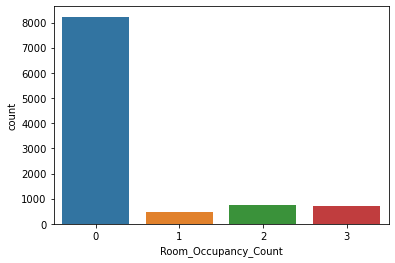

In [7]:
sns.countplot(x='Room_Occupancy_Count',data= data)

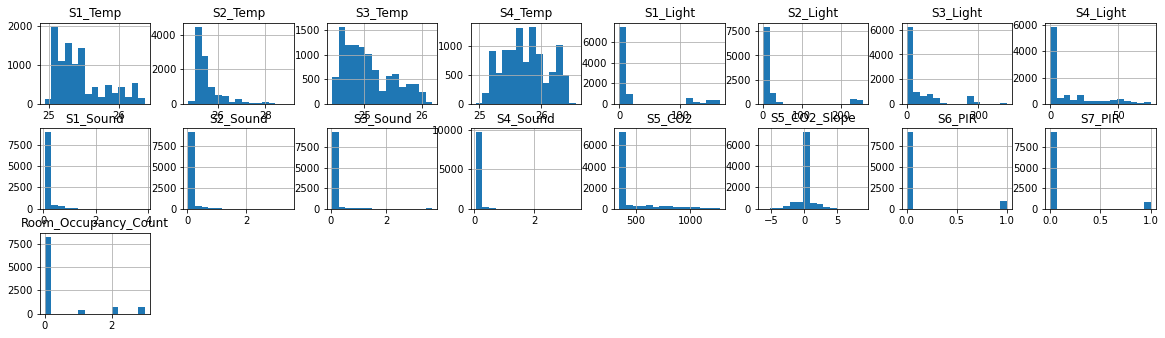

In [8]:
# Visualize distributions of features
data.hist(bins=15, figsize=(20, 15), layout=(8, 8))
plt.show()

(10.0, 0.0)

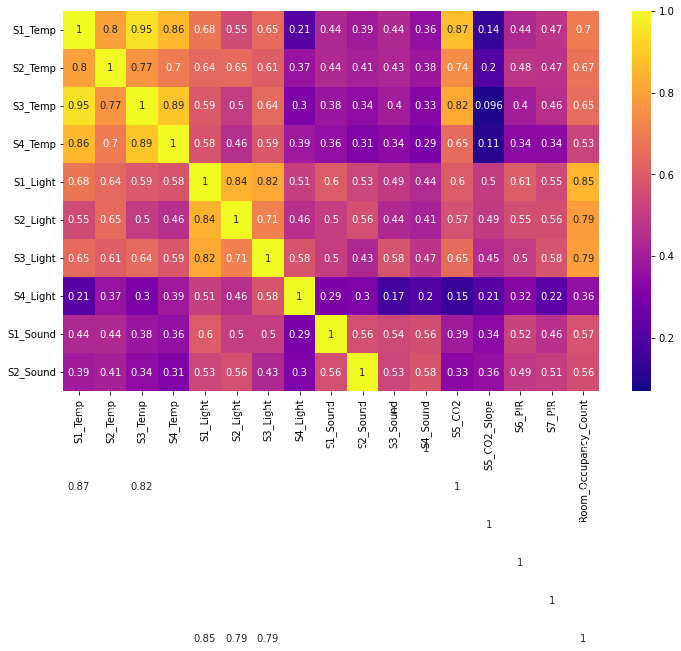

In [9]:
plt.figure(figsize=(12,7))
sns.heatmap(data.corr(),annot=True,cmap='plasma')
plt.ylim(10, 0)

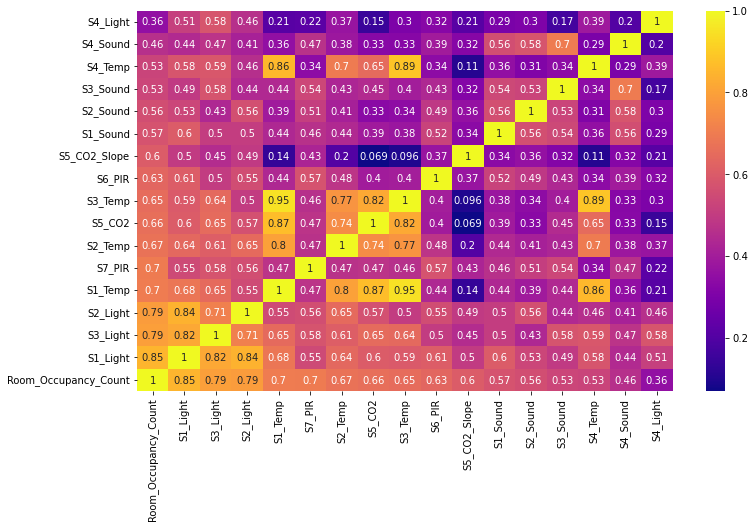

In [10]:
corr = data.corr().sort_values('Room_Occupancy_Count', axis=1, ascending=False)
corr = corr.sort_values('Room_Occupancy_Count', axis=0, ascending=True)
plt.figure(figsize=(12,7))
sns.heatmap(corr,cmap='plasma',annot=True)
plt.show()

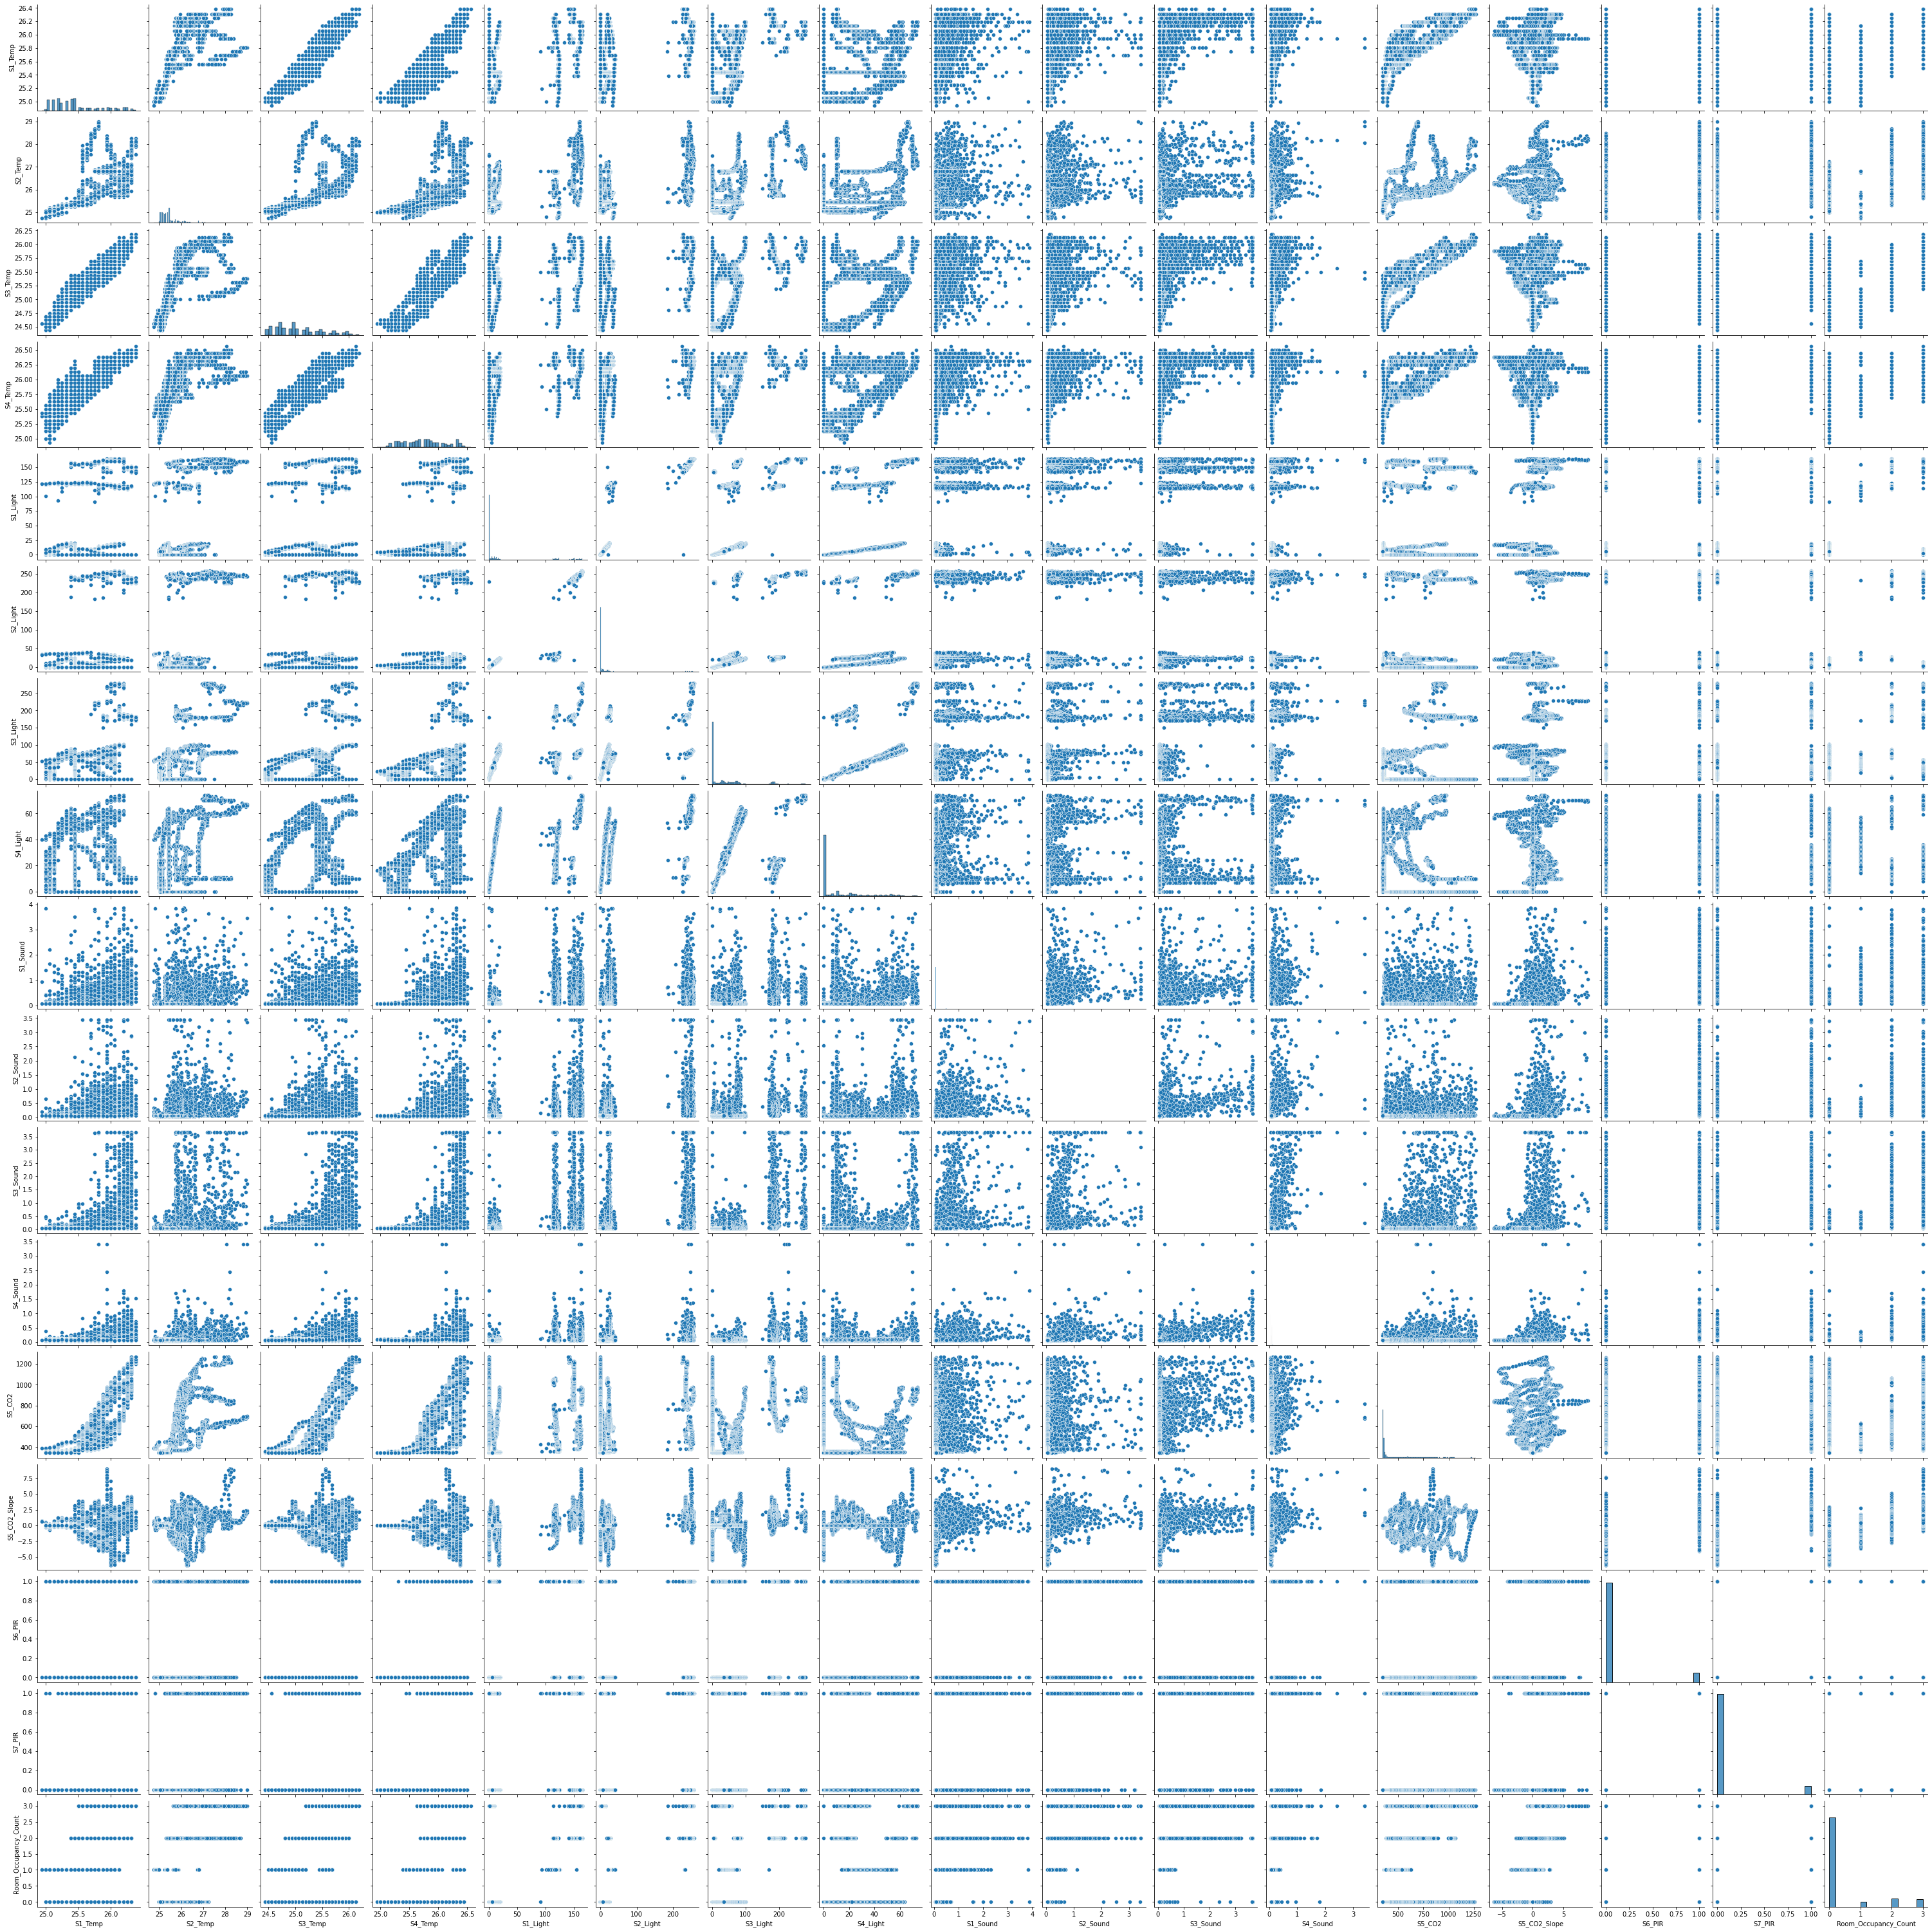

In [11]:
# Pair plot to visualize relationships between features
sns.pairplot(data)
plt.show()

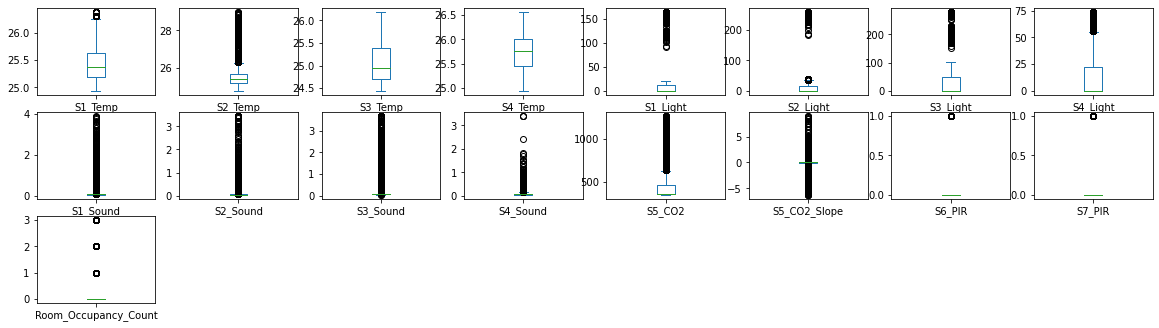

In [12]:
# Boxplots to check for outliers
data.plot(kind='box', subplots=True, layout=(8,8), sharex=False, sharey=False, figsize=(20, 15))
plt.show()

### Data Preprocessing

### Checking for duplicate values and handling duplicate values 

In [13]:
data[data.duplicated()]

,Date,Time,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count


In [14]:
data.drop(columns=['Time'],axis=1, inplace=True)

In [15]:
data[data.duplicated()]

,Date,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
1367,2017/12/22,25.50,25.50,25.06,25.81,0,0,0,0,0.07,0.05,0.06,0.06,390,0.000000,0,0,0
1371,2017/12/22,25.50,25.50,25.06,25.81,0,0,0,0,0.07,0.05,0.06,0.06,390,0.000000,0,0,0
1389,2017/12/22,25.44,25.44,25.00,25.75,0,0,0,0,0.06,0.04,0.06,0.06,385,-0.288462,0,0,0
1407,2017/12/22,25.44,25.44,25.00,25.81,0,0,0,0,0.07,0.05,0.06,0.07,385,0.000000,0,0,0
1409,2017/12/22,25.44,25.44,25.06,25.81,0,0,0,0,0.07,0.05,0.06,0.06,385,0.000000,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10075,2018/01/11,25.13,25.06,24.63,25.19,6,6,31,21,0.08,0.05,0.06,0.09,345,0.000000,0,0,0
10084,2018/01/11,25.13,25.06,24.63,25.19,6,7,32,21,0.08,0.05,0.05,0.08,345,0.000000,0,0,0
10098,2018/01/11,25.13,25.06,24.63,25.19,6,7,32,21,0.08,0.05,0.05,0.08,345,0.000000,0,0,0
10117,2018/01/11,25.13,25.06,24.69,25.19,6,7,33,22,0.08,0.05,0.06,0.09,345,0.000000,0,0,0


In [16]:
data = data.drop_duplicates()
data[data.duplicated()]

,Date,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count


### Checking for missing values and handling missing values 

In [17]:
print(data.isnull().sum())

Date                    0
S1_Temp                 0
S2_Temp                 0
S3_Temp                 0
S4_Temp                 0
S1_Light                0
S2_Light                0
S3_Light                0
S4_Light                0
S1_Sound                0
S2_Sound                0
S3_Sound                0
S4_Sound                0
S5_CO2                  0
S5_CO2_Slope            0
S6_PIR                  0
S7_PIR                  0
Room_Occupancy_Count    0
dtype: int64


In [18]:
data['Date'].value_counts()

2017/12/23    2625
2017/12/25    1613
2017/12/22    1445
2018/01/10     952
2017/12/24     895
2017/12/26     709
2018/01/11     626
Name: Date, dtype: int64

In [19]:
# Encoding multi-categorical variable with one hot encoder
data = pd.get_dummies(data, columns=['Date'])

In [20]:
data

,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,...,S6_PIR,S7_PIR,Room_Occupancy_Count,Date_2017/12/22,Date_2017/12/23,Date_2017/12/24,Date_2017/12/25,Date_2017/12/26,Date_2018/01/10,Date_2018/01/11
0,24.94,24.75,24.56,25.38,121,34,53,40,0.08,0.19,...,0,0,1,1,0,0,0,0,0,0
1,24.94,24.75,24.56,25.44,121,33,53,40,0.93,0.05,...,0,0,1,1,0,0,0,0,0,0
2,25.00,24.75,24.50,25.44,121,34,53,40,0.43,0.11,...,0,0,1,1,0,0,0,0,0,0
3,25.00,24.75,24.56,25.44,121,34,53,40,0.41,0.10,...,0,0,1,1,0,0,0,0,0,0
4,25.00,24.75,24.56,25.44,121,34,54,40,0.18,0.06,...,0,0,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10124,25.06,25.13,24.69,25.31,6,7,33,22,0.09,0.04,...,0,0,0,0,0,0,0,0,0,1
10125,25.06,25.06,24.69,25.25,6,7,34,22,0.07,0.05,...,0,0,0,0,0,0,0,0,0,1
10126,25.13,25.06,24.69,25.25,6,7,34,22,0.11,0.05,...,0,0,0,0,0,0,0,0,0,1
10127,25.13,25.06,24.69,25.25,6,7,34,22,0.08,0.08,...,0,0,0,0,0,0,0,0,0,1


In [138]:
data.columns

Index(['S1_Temp', 'S2_Temp', 'S3_Temp', 'S4_Temp', 'S1_Light', 'S2_Light',
       'S3_Light', 'S4_Light', 'S1_Sound', 'S2_Sound', 'S3_Sound', 'S4_Sound',
       'S5_CO2', 'S5_CO2_Slope', 'S6_PIR', 'S7_PIR', 'Room_Occupancy_Count',
       'Date_2017/12/22', 'Date_2017/12/23', 'Date_2017/12/24',
       'Date_2017/12/25', 'Date_2017/12/26', 'Date_2018/01/10',
       'Date_2018/01/11'],
      dtype='object')

### Splitting dataset into train and test set

In [215]:
# Defining features and target variable

# Dataset 
X = data.drop(['Room_Occupancy_Count'], axis=1)

# Target variable
y = data['Room_Occupancy_Count']

In [216]:
# Splitting dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [217]:
# Initialize a scaler
scaler = StandardScaler()

# Scale data with the date encoded
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Binarize the labels for AUC calculation
classes = np.unique(y_train)
y_bin = label_binarize(y_train, classes=classes)

### Implementing a neural network, random forest, gradient boosting and logistic regression algorithms while comparing the performance via AUC and Accuracy

In [25]:
# Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=3000, multi_class='ovr', solver='lbfgs'),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Neural Network": MLPClassifier(hidden_layer_sizes=(100,), max_iter=3000, activation='relu', solver='adam', random_state=42)
}

In [26]:
model_accuracy = {}
model_auc_scores = {}

# Initialize DataFrame to store results
results_df = pd.DataFrame(columns=['Model', 'Accuracy', 'AUC Score'])

# Evaluate each model
for name, model in models.items():
    # Fit model
    model.fit(X_train, y_train)
    
    # Make predictions
    predictions = model.predict(X_test)
    probabilities = model.predict_proba(X_test)
    
    # Binarize the output for each class for AUC computation
    y_test_bin = label_binarize(y_test, classes=classes)
    
    # Calculate Accuracy
    accuracy = accuracy_score(y_test, predictions)
    model_accuracy[name] = accuracy
    
    # Calculate AUC Score
    # Handle multi-class by using one-vs-rest (OvR) approach
    auc_score = roc_auc_score(y_test_bin, probabilities, multi_class='ovr', average='macro')
    model_auc_scores[name] = auc_score  # Store AUC score in the dictionary
    
    # Append to DataFrame
    results_df = results_df.append({
    'Model': name,
    'Accuracy': accuracy,
    'AUC Score': auc_score
    }, ignore_index=True)
    
    # Print Evaluation Metrics
    print(f"--- {name} ---")
    print("Accuracy:", accuracy)
    print("AUC Score:", auc_score)
    print("Classification Report:")
    print(classification_report(y_test, predictions))
    

/var/folders/bm/c6nxjtyx6wv6k7ts702tqk5r0000gn/T/ipykernel_8274/1822162270.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


--- Logistic Regression ---
Accuracy: 0.9939849624060151
AUC Score: 0.999463612846738
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2125
           1       1.00      0.99      1.00       133
           2       0.97      0.97      0.97       209
           3       0.96      0.96      0.96       193

    accuracy                           0.99      2660
   macro avg       0.98      0.98      0.98      2660
weighted avg       0.99      0.99      0.99      2660



/var/folders/bm/c6nxjtyx6wv6k7ts702tqk5r0000gn/T/ipykernel_8274/1822162270.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


--- Random Forest ---
Accuracy: 0.9984962406015038
AUC Score: 0.9999767558757473
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2125
           1       1.00      0.99      1.00       133
           2       1.00      0.99      0.99       209
           3       0.99      0.99      0.99       193

    accuracy                           1.00      2660
   macro avg       1.00      0.99      1.00      2660
weighted avg       1.00      1.00      1.00      2660



/var/folders/bm/c6nxjtyx6wv6k7ts702tqk5r0000gn/T/ipykernel_8274/1822162270.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


--- Gradient Boosting ---
Accuracy: 0.9977443609022556
AUC Score: 0.9999647299977308
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2125
           1       1.00      0.99      1.00       133
           2       0.99      1.00      0.99       209
           3       0.99      0.98      0.99       193

    accuracy                           1.00      2660
   macro avg       1.00      0.99      0.99      2660
weighted avg       1.00      1.00      1.00      2660

--- Neural Network ---
Accuracy: 0.9954887218045113
AUC Score: 0.9998757788948864
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2125
           1       1.00      0.99      1.00       133
           2       0.97      0.98      0.97       209
           3       0.98      0.96      0.97       193

    accuracy                           1.00      2660
   macro avg       0.99   

/var/folders/bm/c6nxjtyx6wv6k7ts702tqk5r0000gn/T/ipykernel_8274/1822162270.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


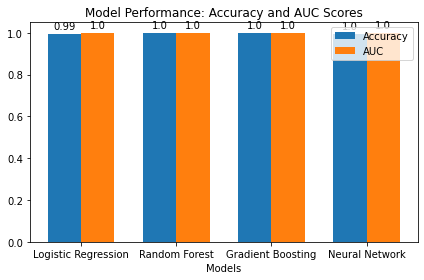

In [27]:
# Visualization of the model performance
labels = list(model_accuracy.keys())
accuracy_scores = list(model_accuracy.values())
auc_scores = list(model_auc_scores.values())

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, accuracy_scores, width, label='Accuracy')
rects2 = ax.bar(x + width/2, auc_scores, width, label='AUC')

# Add text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Models')
ax.set_title('Model Performance: Accuracy and AUC Scores')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Function to attach a text label above each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

In [28]:
# Display results
print(results_df)

                 Model  Accuracy  AUC Score
0  Logistic Regression  0.993985   0.999464
1        Random Forest  0.998496   0.999977
2    Gradient Boosting  0.997744   0.999965
3       Neural Network  0.995489   0.999876


### Applying PCA to the Dataset

Explained Variance Ratio per Principal Component:  [3.77583449e-01 9.62856692e-02 7.01417064e-02 6.08938021e-02
 5.33726694e-02 4.85921999e-02 4.85639830e-02 4.60990544e-02
 3.45095803e-02 2.50880470e-02 2.39921416e-02 2.13966065e-02
 2.05453516e-02 1.64303500e-02 1.40627410e-02 1.32982026e-02
 1.14881081e-02 8.11072605e-03 4.68949813e-03 3.14637648e-03
 1.09744947e-03 6.12288068e-04 8.05655180e-33]
Cummulative Variance:  [0.37758345 0.47386912 0.54401082 0.60490463 0.6582773  0.7068695
 0.75543348 0.80153253 0.83604211 0.86113016 0.8851223  0.90651891
 0.92706426 0.94349461 0.95755735 0.97085555 0.98234366 0.99045439
 0.99514389 0.99829026 0.99938771 1.         1.        ]


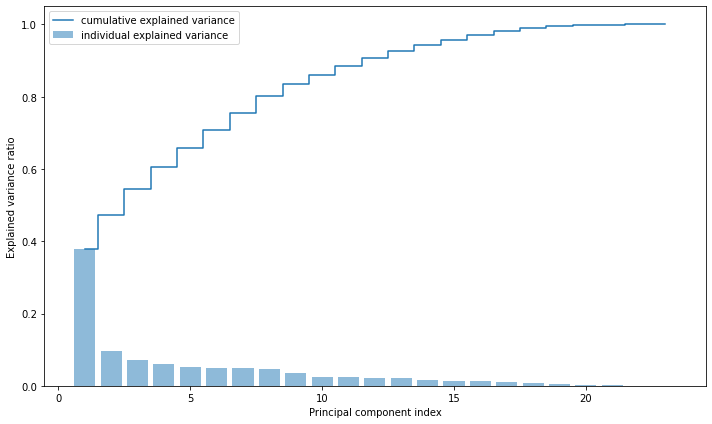

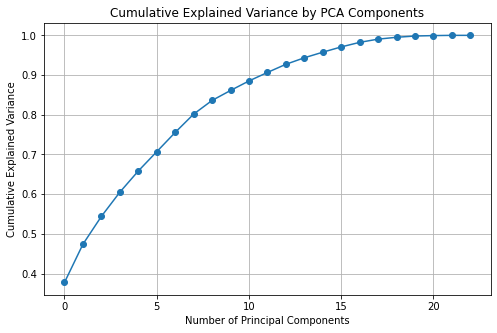

In [29]:
pca = PCA()
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_

# Cumulative explained variance
cumulative_variance = np.cumsum(explained_variance)
print("Explained Variance Ratio per Principal Component: ", explained_variance)
print("Cummulative Variance: ", cumulative_variance)

# Plotting explained variances
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# Plotting cumultaive variance
plt.figure(figsize=(8, 5))
plt.plot(cumulative_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PCA Components')
plt.grid(True)
plt.show()


### Feature Selection

### Bi-Directional Elimination as a wrapper method

In [30]:
%%time

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
# Bi-directional Sequential Selection(sffs)
sffs = SFS(RandomForestClassifier(),
           k_features = (1, len(X.columns)),
           forward = True,
           floating = True,
           scoring = 'accuracy',
           cv=5)
sffs.fit(X, y)
corr_features = list(sffs.k_feature_names_)
corr_features

CPU times: user 19min 10s, sys: 5.78 s, total: 19min 16s
Wall time: 19min 17s


['S2_Temp',
 'S1_Light',
 'S2_Light',
 'S3_Light',
 'S4_Light',
 'S7_PIR',
 'Date_2017/12/22',
 'Date_2017/12/24',
 'Date_2017/12/25',
 'Date_2018/01/10']

In [32]:
X_final = X[corr_features]
X_final.head()

,S2_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S7_PIR,Date_2017/12/22,Date_2017/12/24,Date_2017/12/25,Date_2018/01/10
0,24.75,121,34,53,40,0,1,0,0,0
1,24.75,121,33,53,40,0,1,0,0,0
2,24.75,121,34,53,40,0,1,0,0,0
3,24.75,121,34,53,40,0,1,0,0,0
4,24.75,121,34,54,40,0,1,0,0,0


### Model after feature selection algorithm 

In [106]:
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X_final, y, test_size=0.3, random_state=42)

In [107]:
# Dictionary to store results
model_accuracy_final = {}
model_auc_scores_final = {}

# Initialize DataFrame to store results
results_data = pd.DataFrame(columns=['Model', 'Accuracy', 'AUC Score'])

# Evaluate each model
for name, model in models.items():
    # Fit model
    model.fit(X_train_final, y_train)
    
    # Make predictions
    predictions = model.predict(X_test_final)
    probabilities = model.predict_proba(X_test_final)
    
    # Binarize the output for each class for AUC computation
    y_test_bin = label_binarize(y_test, classes=classes)
    
    # Calculate Accuracy
    accuracy = accuracy_score(y_test, predictions)
    model_accuracy[name] = accuracy
    
    # Calculate AUC Score
    # Handle multi-class by using one-vs-rest (OvR) approach
    auc_score = roc_auc_score(y_test_bin, probabilities, multi_class='ovr', average='macro')
    model_auc_scores[name] = auc_score  # Store AUC score in the dictionary
    
    # Append to DataFrame
    results_data = results_data.append({
    'Model': name,
    'Accuracy': accuracy,
    'AUC Score': auc_score
    }, ignore_index=True)
    
    # Print Evaluation Metrics
    print(f"--- {name} ---")
    print("Accuracy:", accuracy)
    print("AUC Score:", auc_score)
    print("Classification Report:")
    print(classification_report(y_test, predictions))

/var/folders/bm/c6nxjtyx6wv6k7ts702tqk5r0000gn/T/ipykernel_8274/2496063119.py:30: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



--- Logistic Regression ---
Accuracy: 0.9849624060150376
AUC Score: 0.9990399181860565
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2125
           1       1.00      0.99      1.00       133
           2       0.96      0.91      0.94       209
           3       0.89      0.91      0.90       193

    accuracy                           0.98      2660
   macro avg       0.96      0.95      0.96      2660
weighted avg       0.98      0.98      0.98      2660



/var/folders/bm/c6nxjtyx6wv6k7ts702tqk5r0000gn/T/ipykernel_8274/2496063119.py:30: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



--- Random Forest ---
Accuracy: 0.9977443609022556
AUC Score: 0.9999817815764401
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2125
           1       0.99      0.99      0.99       133
           2       0.99      0.99      0.99       209
           3       0.99      0.99      0.99       193

    accuracy                           1.00      2660
   macro avg       0.99      0.99      0.99      2660
weighted avg       1.00      1.00      1.00      2660



/var/folders/bm/c6nxjtyx6wv6k7ts702tqk5r0000gn/T/ipykernel_8274/2496063119.py:30: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



--- Gradient Boosting ---
Accuracy: 0.9981203007518797
AUC Score: 0.9998991162590499
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2125
           1       0.99      0.99      0.99       133
           2       0.99      1.00      0.99       209
           3       1.00      0.98      0.99       193

    accuracy                           1.00      2660
   macro avg       0.99      0.99      0.99      2660
weighted avg       1.00      1.00      1.00      2660

--- Neural Network ---
Accuracy: 0.9958646616541353
AUC Score: 0.999062462677715
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2125
           1       1.00      0.99      1.00       133
           2       0.98      0.98      0.98       209
           3       0.97      0.97      0.97       193

    accuracy                           1.00      2660
   macro avg       0.99    

/var/folders/bm/c6nxjtyx6wv6k7ts702tqk5r0000gn/T/ipykernel_8274/2496063119.py:30: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [108]:
print(results_data)

                 Model  Accuracy  AUC Score
0  Logistic Regression  0.984962   0.999040
1        Random Forest  0.997744   0.999982
2    Gradient Boosting  0.998120   0.999899
3       Neural Network  0.995865   0.999062


### Comaprison of Model before and after feature selection

In [109]:
comparison_df = pd.concat([results_df.set_index('Model'), results_data.set_index('Model')], axis=1, keys=['Original', 'After Feature Selection'])
print(comparison_df)

                     Original           After Feature Selection          
                     Accuracy AUC Score                Accuracy AUC Score
Model                                                                    
Logistic Regression  0.993985  0.999464                0.984962  0.999040
Random Forest        0.998496  0.999977                0.997744  0.999982
Gradient Boosting    0.997744  0.999965                0.998120  0.999899
Neural Network       0.995489  0.999876                0.995865  0.999062


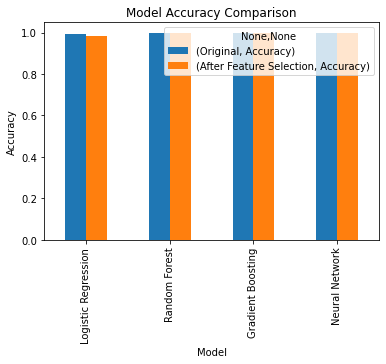

In [110]:
import matplotlib.pyplot as plt

# Plotting comparison of Accuracy before and after feature selection
comparison_df.plot(kind='bar', y=[('Original', 'Accuracy'), ('After Feature Selection', 'Accuracy')])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.show()

### Explainable AI with random forest algorithm using feature importance before feature selection

In [218]:
clf_1 = RandomForestClassifier(n_estimators = 100, random_state=42)
clf_1.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

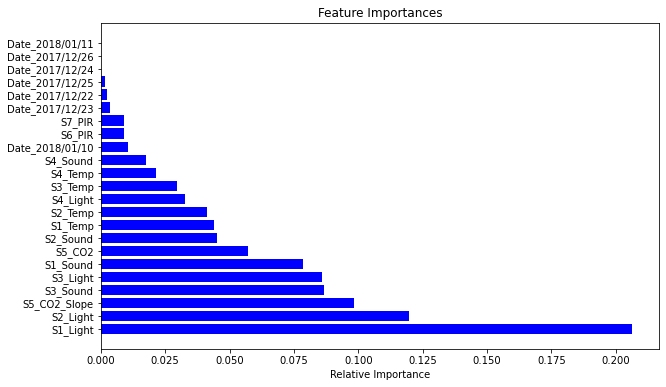

In [219]:
# Get feature importances
importances = clf_1.feature_importances_
indices = pd.Series(X.columns)[np.argsort(importances)[::-1]]

# Visualize feature importances
plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[np.argsort(importances)[::-1]], color='b', align='center')
plt.yticks(range(len(indices)), indices)
plt.xlabel('Relative Importance')
plt.show()

In [220]:
sample_indices = [200, 500, 1000, 450, 700]  # Sample indices for explanation
for i in sample_indices:
    sample = X.iloc[i]
    prediction = clf_1.predict([sample.values])[0]
    print(f"Sample {i} prediction: {prediction}")
    print("Feature contributions:")
    for feature, importance in zip(X.columns, clf_1.feature_importances_):
        print(f"{feature}: {importance:.4f} (value: {sample[feature]})")


Sample 200 prediction: 3
Feature contributions:
S1_Temp: 0.0441 (value: 25.75)
S2_Temp: 0.0412 (value: 28.69)
S3_Temp: 0.0294 (value: 25.31)
S4_Temp: 0.0214 (value: 26.06)
S1_Light: 0.2064 (value: 159.0)
S2_Light: 0.1199 (value: 245.0)
S3_Light: 0.0858 (value: 216.0)
S4_Light: 0.0325 (value: 65.0)
S1_Sound: 0.0785 (value: 0.62)
S2_Sound: 0.0453 (value: 0.74)
S3_Sound: 0.0868 (value: 0.19)
S4_Sound: 0.0174 (value: 0.13)
S5_CO2: 0.0570 (value: 665.0)
S5_CO2_Slope: 0.0983 (value: 0.707692307692)
S6_PIR: 0.0089 (value: 1.0)
S7_PIR: 0.0089 (value: 0.0)
Date_2017/12/22: 0.0024 (value: 1.0)
Date_2017/12/23: 0.0035 (value: 0.0)
Date_2017/12/24: 0.0000 (value: 0.0)
Date_2017/12/25: 0.0017 (value: 0.0)
Date_2017/12/26: 0.0000 (value: 0.0)
Date_2018/01/10: 0.0107 (value: 0.0)
Date_2018/01/11: 0.0000 (value: 0.0)
Sample 500 prediction: 3
Feature contributions:
S1_Temp: 0.0441 (value: 25.94)
S2_Temp: 0.0412 (value: 25.81)
S3_Temp: 0.0294 (value: 25.63)
S4_Temp: 0.0214 (value: 26.38)
S1_Light: 0.206

### Explainable AI with random forest algorithm using feature importance after feature selection

In [223]:
clf = RandomForestClassifier(n_estimators = 100, random_state=42) ## Explainable AI with random forest algorithm using feature importance before feature selection(n_estimators = 100, random_state=42)
clf.fit(X_train_final, y_train_final)

RandomForestClassifier(random_state=42)

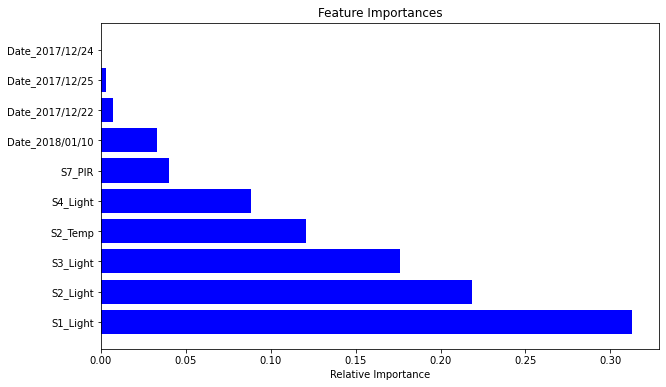

In [224]:
# Get feature importances
importances = clf.feature_importances_
indices = pd.Series(X_final.columns)[np.argsort(importances)[::-1]]

# Visualize feature importances
plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[np.argsort(importances)[::-1]], color='b', align='center')
plt.yticks(range(len(indices)), indices)
plt.xlabel('Relative Importance')
plt.show()

In [235]:
sample_indices = [200, 300, 10, 450, 70]  # Sample indices for explanation
for i in sample_indices:
    sample = X_final.iloc[i]
    prediction = clf.predict([sample.values])[0]
    print(f"Sample {i} prediction: {prediction}")
    print("Feature contributions:")
    for feature, importance in zip(X_final.columns, clf.feature_importances_):
        print(f"{feature}: {importance:.4f} (value: {sample[feature]})")


Sample 200 prediction: 2
Feature contributions:
S2_Temp: 0.1206 (value: 28.69)
S1_Light: 0.3129 (value: 159.0)
S2_Light: 0.2184 (value: 245.0)
S3_Light: 0.1762 (value: 216.0)
S4_Light: 0.0882 (value: 65.0)
S7_PIR: 0.0404 (value: 0.0)
Date_2017/12/22: 0.0070 (value: 1.0)
Date_2017/12/24: 0.0000 (value: 0.0)
Date_2017/12/25: 0.0031 (value: 0.0)
Date_2018/01/10: 0.0332 (value: 0.0)
Sample 300 prediction: 3
Feature contributions:
S2_Temp: 0.1206 (value: 27.06)
S1_Light: 0.3129 (value: 165.0)
S2_Light: 0.2184 (value: 255.0)
S3_Light: 0.1762 (value: 275.0)
S4_Light: 0.0882 (value: 70.0)
S7_PIR: 0.0404 (value: 1.0)
Date_2017/12/22: 0.0070 (value: 1.0)
Date_2017/12/24: 0.0000 (value: 0.0)
Date_2017/12/25: 0.0031 (value: 0.0)
Date_2018/01/10: 0.0332 (value: 0.0)
Sample 10 prediction: 1
Feature contributions:
S2_Temp: 0.1206 (value: 24.81)
S1_Light: 0.3129 (value: 122.0)
S2_Light: 0.2184 (value: 35.0)
S3_Light: 0.1762 (value: 57.0)
S4_Light: 0.0882 (value: 43.0)
S7_PIR: 0.0404 (value: 1.0)
Date_

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



### Explainable AI with SHAP before feature selection

In [230]:
# Initialize the SHAP explainer
explainer = shap.TreeExplainer(clf_1)
shap_values = explainer.shap_values(X)

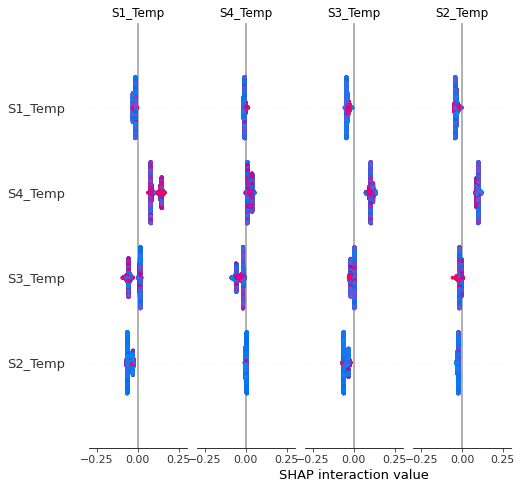

In [231]:
shap.summary_plot(shap_values, X, plot_type = 'bar')

### Explainable AI with SHAP after feature selection

In [232]:
# Initialize the SHAP explainer
explainer1 = shap.TreeExplainer(clf)
shap_values = explainer1.shap_values(X_final)

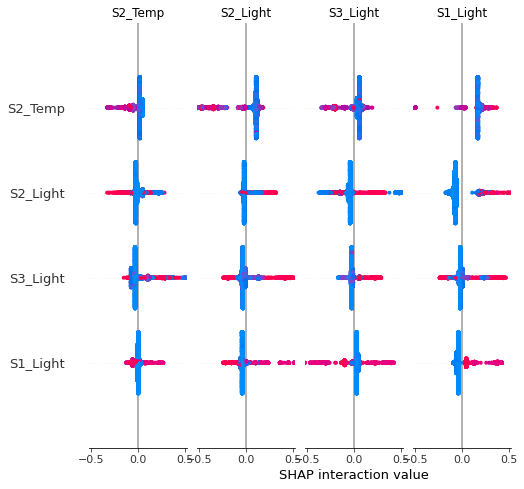

In [234]:
shap.summary_plot(shap_values, X_final, plot_type = 'bar')